In [42]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [43]:
# Sentiment dataset
sentiment = pd.read_csv("fear_greed_index.csv")

# Convert Unix timestamp -> datetime (floor to day)
sentiment['Date'] = pd.to_datetime(sentiment['timestamp'], unit='s').dt.floor('d')
sentiment['Sentiment'] = sentiment['classification'].map({'Fear': 0, 'Greed': 1})

# Ensure full daily coverage (forward-fill)
sentiment = sentiment.set_index('Date').resample('D').ffill().reset_index()

# Trader dataset
trades = pd.read_csv("historical_data.csv")

# Convert IST timestamps
trades['Timestamp'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors="coerce")

# Add trade date column for merging
trades['date'] = pd.to_datetime(trades['Timestamp'].dt.date)



In [44]:
# Merge Sentiment with Trades
df = trades.merge(sentiment[['Date','Sentiment']], left_on='date', right_on='Date', how='left')
df.drop(columns=['Date'], inplace=True)

# If still NaN in Sentiment (dates out of range), fill with previous sentiment
df['Sentiment'] = df['Sentiment'].ffill().bfill()

In [45]:
# 3. Feature Engineering
# Safe proxy leverage
df['proxyLeverage'] = df.apply(
    lambda row: row['Size USD'] / (row['Execution Price'] * row['Size Tokens'])
    if row['Execution Price'] > 0 and row['Size Tokens'] > 0 else np.nan,
    axis=1
)

# Trader-level daily stats
daily_stats = df.groupby(['Account', 'date', 'Sentiment']).agg({
    'Closed PnL': ['mean','sum'],
    'proxyLeverage': 'mean',
    'Size Tokens': 'sum',
    'Side': lambda x: (x.astype(str).str.upper() == 'BUY').mean()
}).reset_index()

# Flatten MultiIndex columns
daily_stats.columns = ['Account','date','Sentiment','avgPnL','totalPnL','avgLeverage','totalSize','buyRatio']

print("Sample of daily stats:")
print(daily_stats.head())
print("Shape of daily_stats:", daily_stats.shape)

Sample of daily stats:
                                      Account       date  Sentiment  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11        1.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17        1.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18        1.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22        1.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26        1.0   

        avgPnL  totalPnL  avgLeverage  totalSize  buyRatio  
0     0.000000       0.0     0.999997      281.0  0.000000  
1     0.000000       0.0     1.000000     1100.0  0.000000  
2     0.000000       0.0     0.999996      300.0  0.000000  
3 -1768.916667  -21227.0     1.000000      100.0  1.000000  
4    59.374074    1603.1     1.000000     2000.0  0.444444  
Shape of daily_stats: (2341, 8)


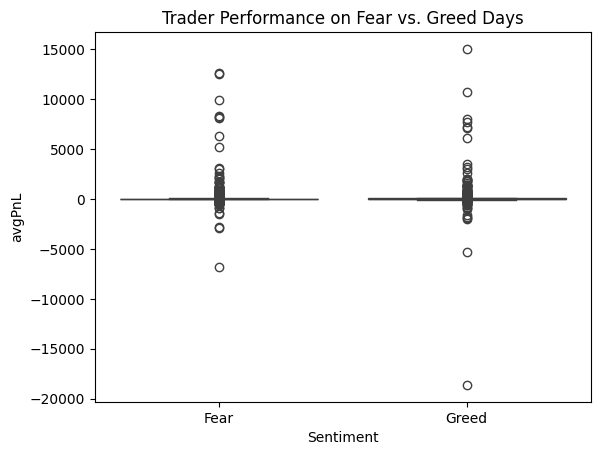

In [46]:
# 4. EDA & Visualization
# Compare avgPnL in Fear vs Greed
if not daily_stats.empty:
    sns.boxplot(x='Sentiment', y='avgPnL', data=daily_stats)
    plt.xticks([0,1], ['Fear','Greed'])
    plt.title("Trader Performance on Fear vs. Greed Days")
    plt.show()
else:
    print(" daily_stats is empty — check merge/columns!")

In [47]:
# 5. Statistical Test
from scipy.stats import ttest_ind

fear_pnl = daily_stats.loc[daily_stats['Sentiment']==0, 'avgPnL']
greed_pnl = daily_stats.loc[daily_stats['Sentiment']==1, 'avgPnL']

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False, nan_policy="omit")
    print(f"T-stat: {t_stat:.3f}, P-value: {p_val:.3f}")
else:
    print("Not enough data for t-test")

T-stat: 0.793, P-value: 0.428


In [48]:
# 6. Predictive Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

if not daily_stats.empty:
    X = daily_stats[['avgLeverage','totalSize','buyRatio','Sentiment']].fillna(0)
    y = (daily_stats['avgPnL'] > 0).astype(int)

    if len(y.unique()) > 1:  # ensure both classes exist
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    else:
        print(" Only one class in y, can't train classifier")
else:
    print(" No data for modeling")


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       268
           1       0.80      0.85      0.82       435

    accuracy                           0.78       703
   macro avg       0.77      0.75      0.76       703
weighted avg       0.77      0.78      0.77       703



In [49]:
from sklearn.metrics import classification_report, accuracy_score

# After fitting and predicting
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.3f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       268
           1       0.80      0.85      0.82       435

    accuracy                           0.78       703
   macro avg       0.77      0.75      0.76       703
weighted avg       0.77      0.78      0.77       703

Model Accuracy: 0.777


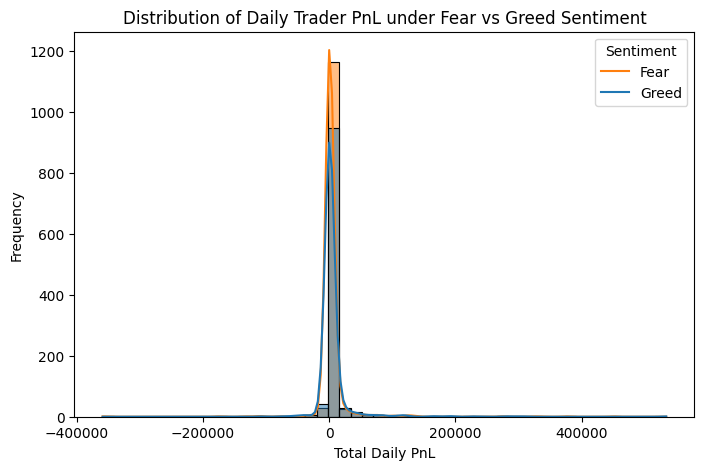

In [50]:
# 7. Advanced Analysis & Insights

# 7.1 Distribution of total PnL across Sentiment
plt.figure(figsize=(8,5))
sns.histplot(data=daily_stats, x='totalPnL', hue='Sentiment', bins=50, kde=True)
plt.title("Distribution of Daily Trader PnL under Fear vs Greed Sentiment")
plt.xlabel("Total Daily PnL")
plt.ylabel("Frequency")
plt.legend(title="Sentiment", labels=["Fear","Greed"])
plt.show()


# This shows whether traders make larger wins/losses during Fear or Greed.
# If tails are heavier in Fear -> losses are larger.
# If tails are heavier in Greed -> wins are larger.

/tmp/ipython-input-2117519356.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=daily_stats, x='Sentiment', y='avgLeverage', ci='sd')


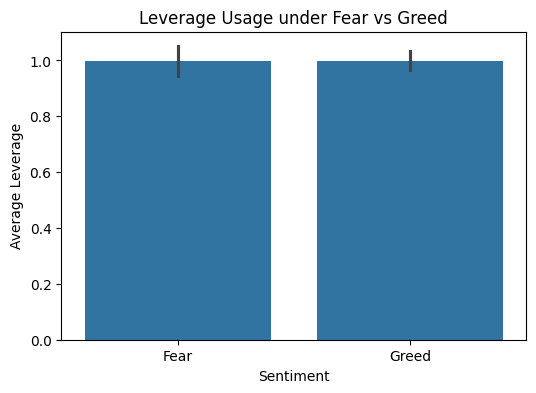

In [36]:
# 7.2 Average leverage used by traders in different sentiments
plt.figure(figsize=(6,4))
sns.barplot(data=daily_stats, x='Sentiment', y='avgLeverage', ci='sd')
plt.xticks([0,1], ['Fear','Greed'])
plt.title("Leverage Usage under Fear vs Greed")
plt.ylabel("Average Leverage")
plt.show()

# 💡 Insight:
# Higher leverage in Greed periods might indicate overconfidence.
# More conservative leverage in Fear periods could mean risk-aversion.

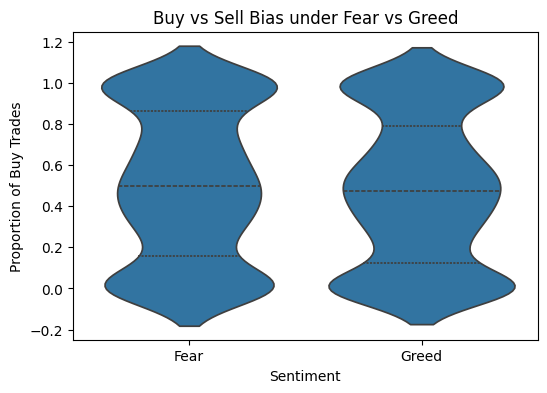

In [38]:
# 7.3 Buy ratio comparison across sentiments
plt.figure(figsize=(6,4))
sns.violinplot(data=daily_stats, x='Sentiment', y='buyRatio', inner="quartile")
plt.xticks([0,1], ['Fear','Greed'])
plt.title("Buy vs Sell Bias under Fear vs Greed")
plt.ylabel("Proportion of Buy Trades")
plt.show()

# 💡 Insight:
# If buyRatio is higher during Greed, traders are chasing bullish momentum.
# If lower in Fear, traders shift to shorting.


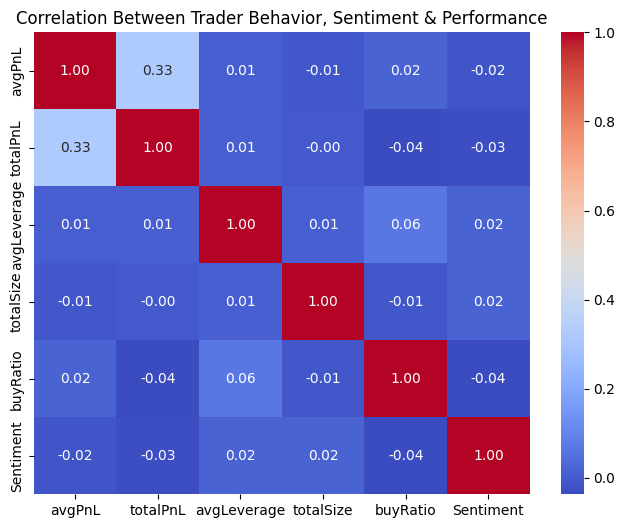

In [39]:
# 7.4 Correlation heatmap (performance vs behavior)
corr = daily_stats[['avgPnL','totalPnL','avgLeverage','totalSize','buyRatio','Sentiment']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Trader Behavior, Sentiment & Performance")
plt.show()

# 💡 Insight:
# Look for strong correlations.
# Example: If avgPnL negatively correlates with leverage → over-leverage leads to losses.
# If Sentiment correlates with buyRatio but not PnL → sentiment drives positioning, not profits.

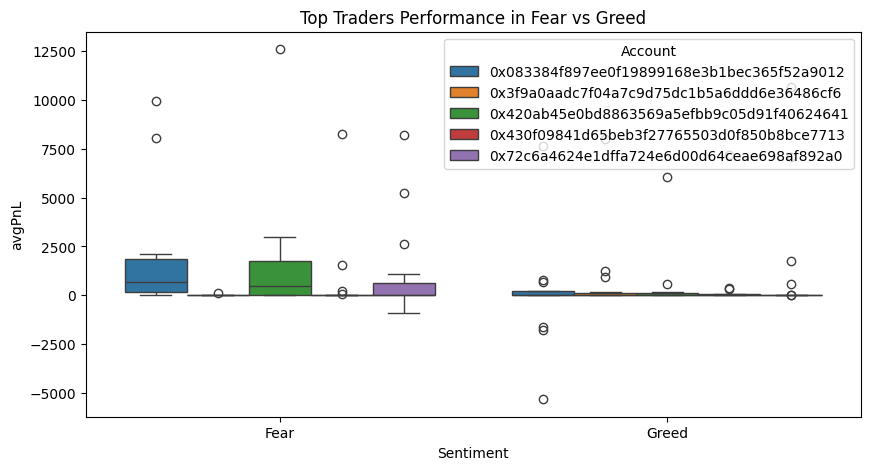

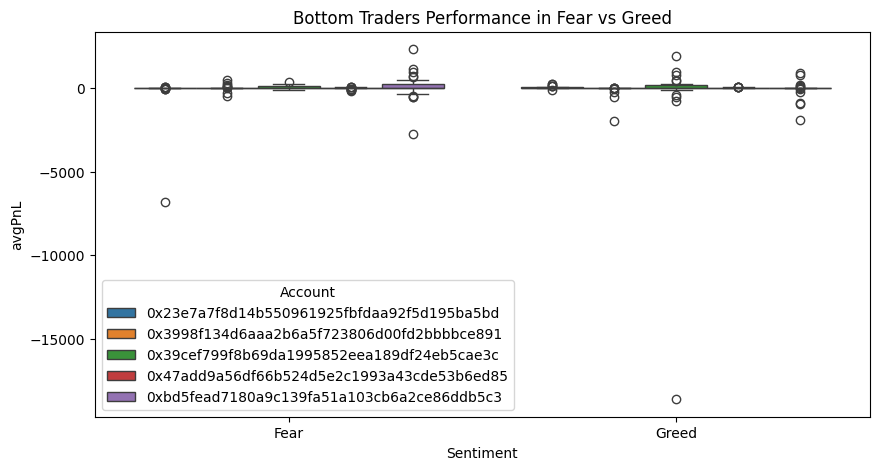

In [40]:
# 7.5 Top vs Bottom performing traders (segmented by sentiment)
top_traders = daily_stats.groupby('Account')['avgPnL'].mean().nlargest(5).index
bottom_traders = daily_stats.groupby('Account')['avgPnL'].mean().nsmallest(5).index

plt.figure(figsize=(10,5))
sns.boxplot(data=daily_stats[daily_stats['Account'].isin(top_traders)], x='Sentiment', y='avgPnL', hue='Account')
plt.xticks([0,1], ['Fear','Greed'])
plt.title("Top Traders Performance in Fear vs Greed")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=daily_stats[daily_stats['Account'].isin(bottom_traders)], x='Sentiment', y='avgPnL', hue='Account')
plt.xticks([0,1], ['Fear','Greed'])
plt.title("Bottom Traders Performance in Fear vs Greed")
plt.show()

# 💡 Insight:
# This lets you comment: “Top traders maintain consistency regardless of sentiment,
# while bottom traders are more sentiment-driven and underperform especially in [Fear/Greed].”


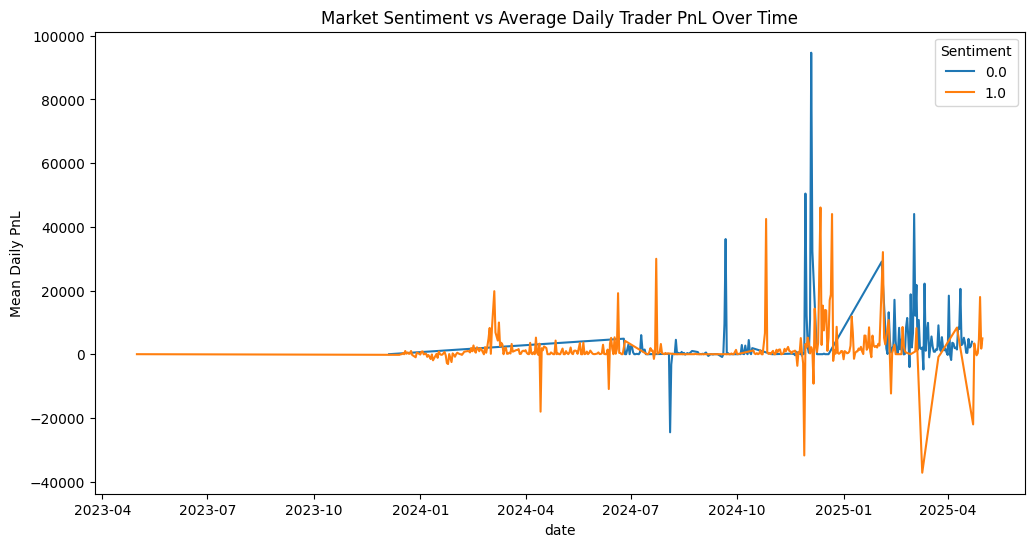

In [41]:
# 7.6 Time-series overlay (PnL trend + sentiment)
pnl_trend = daily_stats.groupby(['date','Sentiment'])['totalPnL'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=pnl_trend, x='date', y='totalPnL', hue='Sentiment')
plt.title("Market Sentiment vs Average Daily Trader PnL Over Time")
plt.ylabel("Mean Daily PnL")
plt.show()

# 💡 Insight:
# This connects performance to market cycles.
# Example: traders profit more during extended Greed runs,
# but sudden Fear days create sharp drawdowns.